## Analyse the performance curve

Drawing the performance curve

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import ipdb
import os
from IPython.display import clear_output as clear

In [335]:
models = ['hred-cf', 'when2talk_GCN', 'GATRNN', 'GatedGCN']
dataset_name = 'dailydialog'
paths = [f'./processed/{dataset_name}/{i}/conclusion.txt' for i in models]
size = 30

In [384]:
def read_file(path, size=20):
    with open(path) as f:
        bleu4, dist1, dist2, acc, macro, micro = [], [], [], [], [], []
        embedding_average = []
        for line in f.readlines():
            line = line.strip()
            if 'BLEU-4' in line:
                bleu4.append(float(line.replace('BLEU-4: ', '')))
            elif 'Vector Extrema' in line:
                embedding_average.append(float(line.replace('Vector Extrema: ', '')))
            elif 'Decision Acc' in line:
                acc.append(float(line.replace('Decision Acc: ', '')))
            elif 'F1' in line:
                ma, mi = line.split(',')
                macro.append(float(ma.replace('Decision macro-F1: ', '')))
                micro.append(float(mi.replace('Decision micro-F1: ', '')))
            elif 'Distinct' in line:
                distinct1, distinct2 = line.split(';')
                dist1.append(float(distinct1.replace('Distinct-1: ', '').strip()))
                dist2.append(float(distinct2.replace('Distinct-2: ', '').strip()))

    assert len(bleu4) == size, f'{len(bleu4)}'
    assert len(embedding_average) == size, f'{len(embedding_average)}'
    assert len(dist1) == size, f'{len(dist1)}'
    assert len(dist2) == size, f'{len(dist2)}'
    
    return (bleu4, embedding_average, dist1, dist2, acc, macro)

In [385]:
def draw_curve(ax1, ax2, ax3, ax4, ax5, ax6,
               bleu4, embedding_average, dist1, dist2, acc, macro, m):
    x = np.arange(1, size + 1)
    
    ax1.plot(x, bleu4, label=m)
    ax1.legend()
    ax1.set_title('BLEU')
    
    ax2.plot(x, embedding_average, label=m)
    ax2.legend()
    ax2.set_title('Embedding Average')
    
    ax3.plot(x, dist1, label=m)
    ax3.legend()
    ax3.set_title('Distinct-1')
    
    ax4.plot(x, dist2, label=m)
    ax4.legend()
    ax4.set_title('Distinct-2')
    
    if acc:
        ax5.plot(x, acc, label=m)
        ax5.legend()
    ax5.set_title('Acc')
    
    if macro:
        ax6.plot(x, macro, label=m)
        ax6.legend()
    ax6.set_title('Macro-F1')

In [386]:
def meta_data(bar, data, min_threshold=0, max_threshold=30):
    try:
        print(f'{bar}: Max data {np.max(data[min_threshold:max_threshold])}, epoch: {1 + np.argmax(data[min_threshold:max_threshold])}')
    except:
        return 

In [387]:
dataset = []
for m, path in zip(models, paths):
    print(f'========== {m} : {path} ==========')
    data = read_file(path, size=size)
    if data:
        dataset.append(data)
        meta_data('BLEU-4', data[0], 
                  min_threshold=10, max_threshold=22)
        meta_data('Embedding Average', data[1], 
                  min_threshold=10, max_threshold=22)
        meta_data('Dist-1', data[2], 
                  min_threshold=10, max_threshold=20)
        meta_data('Dist-2', data[3], 
                  min_threshold=10, max_threshold=20)
        meta_data('Acc', data[4], 
                  min_threshold=10, max_threshold=20)
        meta_data('Macro-F1', data[5], 
                  min_threshold=10, max_threshold=20)

========== hred-cf : ./processed/dailydialog/hred-cf/conclusion.txt ==========
BLEU-4: Max data 0.1721, epoch: 5
Embedding Average: Max data 0.9724, epoch: 1
Dist-1: Max data 0.052, epoch: 10
Dist-2: Max data 0.3182, epoch: 10
Acc: Max data 0.8262385321100918, epoch: 10
Macro-F1: Max data 0.8118872306877031, epoch: 10
========== when2talk_GCN : ./processed/dailydialog/when2talk_GCN/conclusion.txt ==========
BLEU-4: Max data 0.1635, epoch: 1
Embedding Average: Max data 0.9716, epoch: 11
Dist-1: Max data 0.0458, epoch: 10
Dist-2: Max data 0.2864, epoch: 10
Acc: Max data 0.8262385321100918, epoch: 10
Macro-F1: Max data 0.8162133281431387, epoch: 10
========== GATRNN : ./processed/dailydialog/GATRNN/conclusion.txt ==========
BLEU-4: Max data 0.1684, epoch: 8
Embedding Average: Max data 0.9722, epoch: 1
Dist-1: Max data 0.0637, epoch: 10
Dist-2: Max data 0.3759, epoch: 10
Acc: Max data 0.8253211009174312, epoch: 5
Macro-F1: Max data 0.8117807586241368, epoch: 5
========== GatedGCN : ./proce

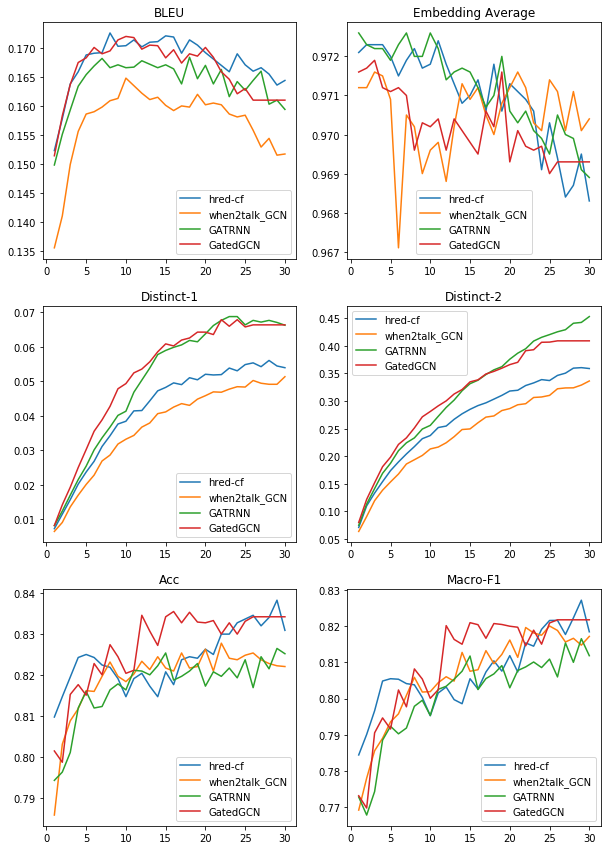

In [388]:
plt.figure(figsize=(10, 20))
sub = [plt.subplot(4, 2, 1), plt.subplot(4, 2, 2), plt.subplot(4, 2, 3),
       plt.subplot(4, 2, 4), plt.subplot(4, 2, 5), plt.subplot(4, 2, 6)]

for d, m in zip(dataset, models):
    draw_curve(*sub, *d, m)
    
plt.savefig(f'./img/{dataset_name}.png')

## Annotate the case
make sure you fix the `translate.py` and add the user information to the `pred.txt`

In [158]:
def read_file(path):
    with open(path) as f:
        src, tgt, pred, label = [], [], [], True
        for idx, line in enumerate(f.readlines()):
            line = line.strip()
            if idx % 4 == 0:
                srcline = line[7:]
            elif idx % 4 == 1:
                if 'silence' in line:
                    label = True
                else:
                    label = False
                tgtline = line[7:]
            elif idx % 4 == 2:
                predline = line[7:]
            elif idx % 4 == 3:
                # if not label:
                #     src.append(srcline)
                #     tgt.append(tgtline)
                src.append(srcline)
                tgt.append(tgtline)
                pred.append(predline)
        assert len(src) == len(tgt), f'tgt: {len(src), len(tgt)}'
        assert len(src) == len(pred), f'pred: {len(src), len(tgt)}'
        result = [(i, j, k) for i, j, k in zip(src, tgt, pred)]
        print(f'{path}: {len(result)}')
        return sorted(result, key=lambda x: x[0])

In [186]:
# show the case
def test_case(d1, d2):
    # get the result that d1 vs. d2
    result = {'win': 0, 'loss': 0, 'tie': 0}
    for idx, (i, j) in enumerate(zip(dggnn, hred_cf)):
        assert i[0] == j[0], 'different context'
        while True:
            print(f'CONTEXT: {i[0]}')
            print(f'REFER: {i[1]}')
            if random.random() > 0.5:
                print(f'REPLY-1: {i[2]}')
                print(f'REPLY-2: {j[2]}')
                label = True
            else:
                print(f'REPLY-1: {j[2]}')
                print(f'REPLY-2: {i[2]}')
                label = False
            a = input(f'{idx}, Continue(w/l/t): ')
            if a not in ['w', 'l', 't']:
                clear()
                print('PLEASE INPUT (win/loss/tie) !!')
            else:
                if (a == 'w' and label) or (a == 'l' and not label):
                    result['win'] += 1 
                elif a == 't':
                    result['tie'] += 1
                else:
                    result['loss'] += 1
                break
        clear()
    return result

In [187]:
# configuration
dataset, cases = 'ubuntu', 100

In [188]:
dggnn = read_file(f'./processed/{dataset}/GatedGCN/pred.txt')
hred_cf = read_file(f'./processed/{dataset}/hred-cf/pred.txt')

# filter
dggnn_context = set([i[0] for i in dggnn])
hred_cf_context = set([i[0] for i in hred_cf])
k = dggnn_context & hred_cf_context

dggnn = [i for i in dggnn if i[0] in k]
hred_cf = [i for i in hred_cf if i[0] in k]

ridx = random.sample(list(range(len(dggnn))), cases)
dggnn = [dggnn[i] for i in ridx]
hred_cf = [hred_cf[i] for i in ridx]

./processed/ubuntu/GatedGCN/pred.txt: 4802
./processed/ubuntu/hred-cf/pred.txt: 5214


In [190]:
result = test_case(dggnn, hred_cf)

CONTEXT: <0> Interesting ... Im sharing a folder on the SMB network , yet other computers cant see it ... wonder why that is __eou__ <0> not running any ... this is a default gutsy install __eou__ <1> try <unk> in a windows address bar __eou__ <0> Yeah I was hoping it wouldnt have to come to that
REFER: <silence>
REPLY-1: <silence>
REPLY-2: <silence>


KeyboardInterrupt: 

In [181]:
result

{'win': 39, 'loss': 12, 'tie': 49}

## Show the cases

In [31]:
dataset = 'ubuntu'

In [ ]:
read